In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

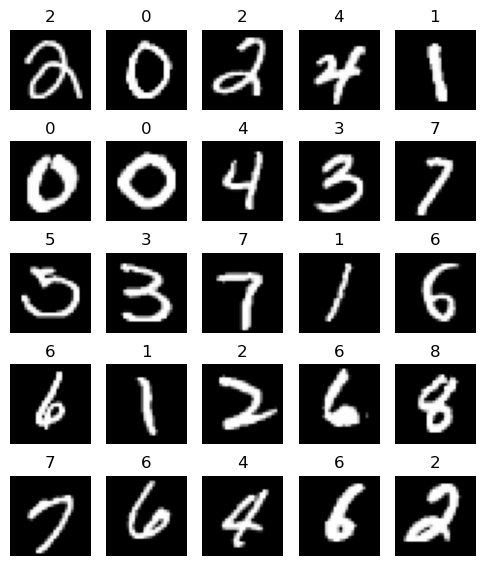

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)
     

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

In [8]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

 Реализуйте инициализацию Xavier. Сравните
ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). (1 балл)

In [9]:
def xavier(layer):

    if isinstance(layer, nn.Linear):
        n_in, n_out = layer.weight.data.size(1), layer.weight.data.size(0)
        a = (6 / (n_in + n_out)) ** 0.5
        nn.init.uniform_(layer.weight.data, -a, a)
        if layer.bias is not None:
            nn.init.constant_(layer.bias.data, 0)

In [46]:
def he(layer):
    if isinstance(layer, nn.Linear):
        n_in = layer.weight.data.size(1)
        std = (2.0 / n_in) ** 0.5
        nn.init.normal_(layer.weight.data, mean=0, std=std)
        if layer.bias is not None:
            nn.init.constant_(layer.bias.data, 0)


print("Xavier")
layer_1_xavier = nn.Linear(28*28, 500)
layer_2_xavier = nn.Linear(500, 10)

layer_1_xavier.register_forward_hook(forward_hook)
layer_2_xavier.register_forward_hook(forward_hook)
layer_1_xavier.register_backward_hook(backward_hook)
layer_2_xavier.register_backward_hook(backward_hook)

xavier(layer_1_xavier)
xavier(layer_2_xavier)

network_xavier = nn.Sequential(
    layer_1_xavier,
    nn.Tanh(),
    layer_2_xavier
)

n_objects = 100
X = torch.randn(n_objects, 28*28)
y = torch.randint(0, 10, (n_objects,))

activations_xavier = network_xavier(X)
loss_fn = torch.nn.CrossEntropyLoss()
loss_xavier = loss_fn(activations_xavier, y)
loss_xavier.backward()


print("\nHe")
layer_1_he = nn.Linear(28*28, 500)
layer_2_he = nn.Linear(500, 10)

layer_1_he.register_forward_hook(forward_hook)
layer_2_he.register_forward_hook(forward_hook)
layer_1_he.register_backward_hook(backward_hook)
layer_2_he.register_backward_hook(backward_hook)

he(layer_1_he)
he(layer_2_he)

network_he = nn.Sequential(
    layer_1_he,
    nn.ReLU(),
    layer_2_he
)

activations_he = network_he(X)
loss_he = loss_fn(activations_he, y)
loss_he.backward()

Xavier
forward 1.0034641027450562
forward 0.6547011137008667
backward 0.028835266828536987
backward 0.0036578504368662834

He
forward 1.0034641027450562
forward 0.8237223029136658
backward 0.08219538629055023
backward 0.008694184012711048


2.1 Реализуйте DropConnect по следующему шаблону: (1 балл)

In [31]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, v):
        if self.training:
            mask = torch.ones_like(self.linear.weight)
            mask = mask.bernoulli_(1 - self.p)
            mask = mask / (1 - self.p)
        else:
            mask = torch.ones_like(self.linear.weight)

        mask = mask.data
        mask.requires_grad = False

        output = F.linear(v, self.linear.weight * mask, self.linear.bias)
        return output

In [32]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.rand_like(x) > self.p
            mask = mask.float() / (1 - self.p)
        else:
            mask = torch.ones_like(x)

        return x * mask

In [33]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

2.2 Сравните графики обучения нейроных сетей (1 балл):

Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев

In [51]:
layers_dropout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(), 
    Dropout(0.5),
    nn.Linear(64, 10)
]

network_dropout = TestNetwork(nn.Sequential(*layers_dropout))
optimizer_dropout = torch.optim.Adam(network_dropout.parameters(), lr=0.001)

In [52]:
layers_dropconnect = [
    DropConnect(196, 128, p=0.3),
    nn.ReLU(),
    DropConnect(128, 64, p=0.3),
    nn.ReLU(),
    nn.Linear(64, 10)
]

network_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))
optimizer_dropconnect = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)

In [53]:
loss_fn = torch.nn.NLLLoss()

dropout_val_losses = []
dropconnect_val_losses = []

In [54]:
for epoch in range(10):
    network_dropout.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer_dropout.zero_grad()
        output = network_dropout(images_train)
        loss = loss_fn(output, labels_train)
        loss.backward()
        optimizer_dropout.step()

    # Обучение DropConnect
    network_dropconnect.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer_dropconnect.zero_grad()
        output = network_dropconnect(images_train)
        loss = loss_fn(output, labels_train)
        loss.backward()
        optimizer_dropconnect.step()

    network_dropout.eval()
    network_dropconnect.eval()
    
    dropout_val_loss = 0
    dropconnect_val_loss = 0
    
    with torch.no_grad():
        for images_test, labels_test in test_loader:
            # Dropout
            output_dropout = network_dropout(images_test)
            dropout_val_loss += loss_fn(output_dropout, labels_test).item()
            
            # DropConnect
            output_dropconnect = network_dropconnect(images_test)
            dropconnect_val_loss += loss_fn(output_dropconnect, labels_test).item()
    
    dropout_val_losses.append(dropout_val_loss / len(test_loader))
    dropconnect_val_losses.append(dropconnect_val_loss / len(test_loader))
    
    print(f'Epoch {epoch}: Dropout Val Loss: {dropout_val_losses[-1]:.4f}, DropConnect Val Loss: {dropconnect_val_losses[-1]:.4f}')



Epoch 0: Dropout Val Loss: 0.2425, DropConnect Val Loss: 0.1906
Epoch 1: Dropout Val Loss: 0.1691, DropConnect Val Loss: 0.1316
Epoch 2: Dropout Val Loss: 0.1333, DropConnect Val Loss: 0.0991
Epoch 3: Dropout Val Loss: 0.1202, DropConnect Val Loss: 0.0947
Epoch 4: Dropout Val Loss: 0.1067, DropConnect Val Loss: 0.0768
Epoch 5: Dropout Val Loss: 0.1044, DropConnect Val Loss: 0.0705
Epoch 6: Dropout Val Loss: 0.0948, DropConnect Val Loss: 0.0706
Epoch 7: Dropout Val Loss: 0.0908, DropConnect Val Loss: 0.0633
Epoch 8: Dropout Val Loss: 0.0890, DropConnect Val Loss: 0.0624
Epoch 9: Dropout Val Loss: 0.0815, DropConnect Val Loss: 0.0621


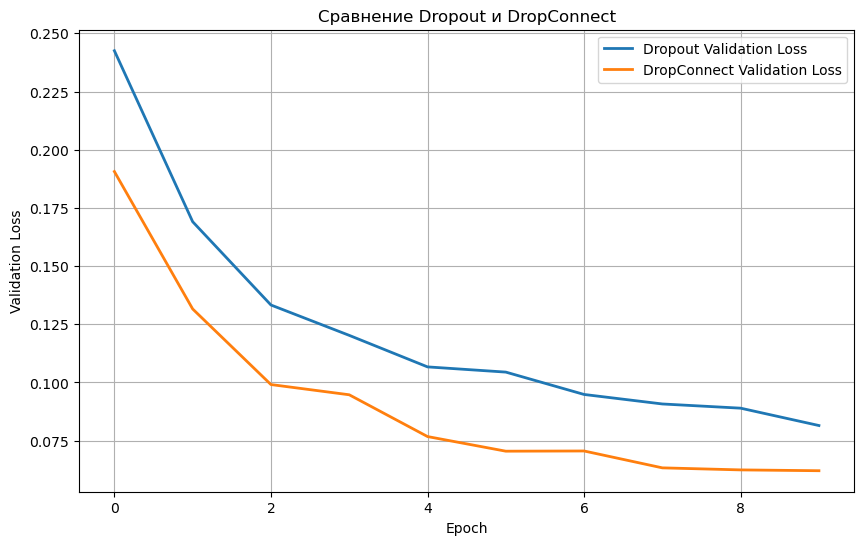

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(dropout_val_losses, label='Dropout Validation Loss', linewidth=2)
plt.plot(dropconnect_val_losses, label='DropConnect Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Сравнение Dropout и DropConnect')
plt.legend()
plt.grid(True)
plt.show()

3.1 Реализуйте Layer Normalization (1 балл)

In [60]:
class LayerNormalization(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x_norm = (x - mean) / (std + self.eps)
        output = self.gamma * x_norm + self.beta
        return output
     

3.2 Сравните графики обучения нейроных сетей (1 балл):

Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

Epoch 0:
  BatchNorm - Val Loss: 0.0968, Val Acc: 0.9684
  LayerNorm - Val Loss: 0.0942, Val Acc: 0.9704
Epoch 1:
  BatchNorm - Val Loss: 0.0945, Val Acc: 0.9701
  LayerNorm - Val Loss: 0.0759, Val Acc: 0.9763
Epoch 2:
  BatchNorm - Val Loss: 0.0725, Val Acc: 0.9756
  LayerNorm - Val Loss: 0.0675, Val Acc: 0.9779
Epoch 3:
  BatchNorm - Val Loss: 0.0681, Val Acc: 0.9782
  LayerNorm - Val Loss: 0.0547, Val Acc: 0.9822
Epoch 4:
  BatchNorm - Val Loss: 0.0597, Val Acc: 0.9807
  LayerNorm - Val Loss: 0.0619, Val Acc: 0.9797
Epoch 5:
  BatchNorm - Val Loss: 0.0592, Val Acc: 0.9812
  LayerNorm - Val Loss: 0.0609, Val Acc: 0.9809
Epoch 6:
  BatchNorm - Val Loss: 0.0647, Val Acc: 0.9798
  LayerNorm - Val Loss: 0.0597, Val Acc: 0.9810
Epoch 7:
  BatchNorm - Val Loss: 0.0578, Val Acc: 0.9822
  LayerNorm - Val Loss: 0.0520, Val Acc: 0.9829
Epoch 8:
  BatchNorm - Val Loss: 0.0698, Val Acc: 0.9809
  LayerNorm - Val Loss: 0.0572, Val Acc: 0.9810
Epoch 9:
  BatchNorm - Val Loss: 0.0663, Val Acc: 0.980

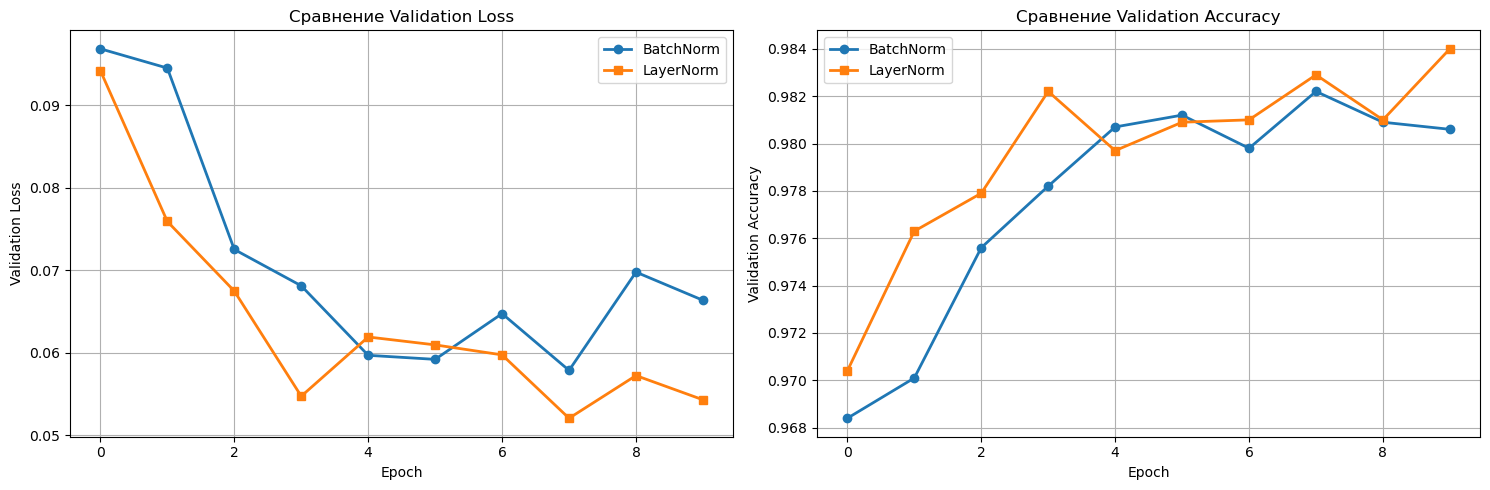

In [63]:
class TestNetworkWithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.flatten = nn.Flatten()
        
        self.final_part = nn.Sequential(
            nn.Linear(196, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

# LayerNorm
class TestNetworkWithLayerNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.flatten = nn.Flatten()
        
        self.final_part = nn.Sequential(
            nn.Linear(196, 128),
            LayerNormalization(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            LayerNormalization(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)


network_batchnorm = TestNetworkWithBatchNorm()
network_layernorm = TestNetworkWithLayerNorm()

optimizer_bn = torch.optim.Adam(network_batchnorm.parameters(), lr=0.001)
optimizer_ln = torch.optim.Adam(network_layernorm.parameters(), lr=0.001)

loss_fn = torch.nn.NLLLoss()

batchnorm_val_losses = []
layernorm_val_losses = []

batchnorm_val_accuracies = []
layernorm_val_accuracies = []

train_losses_batchnorm = []
train_losses_layernorm = []

for epoch in range(10):

    network_batchnorm.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer_bn.zero_grad()
        output = network_batchnorm(images_train)
        loss = loss_fn(output, labels_train)
        loss.backward()
        optimizer_bn.step()

    network_layernorm.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer_ln.zero_grad()
        output = network_layernorm(images_train)
        loss = loss_fn(output, labels_train)
        loss.backward()
        optimizer_ln.step()

    network_batchnorm.eval()
    network_layernorm.eval()
    
    bn_val_loss = 0
    ln_val_loss = 0
    bn_correct = 0
    ln_correct = 0
    total = 0
    
    with torch.no_grad():
        for images_test, labels_test in test_loader:

            output_bn = network_batchnorm(images_test)
            bn_val_loss += loss_fn(output_bn, labels_test).item()
            bn_pred = output_bn.argmax(dim=1)
            bn_correct += (bn_pred == labels_test).sum().item()
            
            output_ln = network_layernorm(images_test)
            ln_val_loss += loss_fn(output_ln, labels_test).item()
            ln_pred = output_ln.argmax(dim=1)
            ln_correct += (ln_pred == labels_test).sum().item()
            
            total += labels_test.size(0)

    batchnorm_val_losses.append(bn_val_loss / len(test_loader))
    layernorm_val_losses.append(ln_val_loss / len(test_loader))
    
    batchnorm_val_accuracies.append(bn_correct / total)
    layernorm_val_accuracies.append(ln_correct / total)

    print(f'Epoch {epoch}:')
    print(f'  BatchNorm - Val Loss: {batchnorm_val_losses[-1]:.4f}, Val Acc: {batchnorm_val_accuracies[-1]:.4f}')
    print(f'  LayerNorm - Val Loss: {layernorm_val_losses[-1]:.4f}, Val Acc: {layernorm_val_accuracies[-1]:.4f}')


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(batchnorm_val_losses, label='BatchNorm', linewidth=2, marker='o')
plt.plot(layernorm_val_losses, label='LayerNorm', linewidth=2, marker='s')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Сравнение Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(batchnorm_val_accuracies, label='BatchNorm', linewidth=2, marker='o')
plt.plot(layernorm_val_accuracies, label='LayerNorm', linewidth=2, marker='s')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Сравнение Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch 0:
  BatchNorm - Train Loss: 0.2412
  LayerNorm - Train Loss: 0.3169
Epoch 1:
  BatchNorm - Train Loss: 0.0751
  LayerNorm - Train Loss: 0.0978
Epoch 2:
  BatchNorm - Train Loss: 0.0531
  LayerNorm - Train Loss: 0.0740
Epoch 3:
  BatchNorm - Train Loss: 0.0447
  LayerNorm - Train Loss: 0.0600
Epoch 4:
  BatchNorm - Train Loss: 0.0376
  LayerNorm - Train Loss: 0.0523
Epoch 5:
  BatchNorm - Train Loss: 0.0315
  LayerNorm - Train Loss: 0.0451
Epoch 6:
  BatchNorm - Train Loss: 0.0266
  LayerNorm - Train Loss: 0.0394
Epoch 7:
  BatchNorm - Train Loss: 0.0240
  LayerNorm - Train Loss: 0.0348
Epoch 8:
  BatchNorm - Train Loss: 0.0227
  LayerNorm - Train Loss: 0.0310
Epoch 9:
  BatchNorm - Train Loss: 0.0187
  LayerNorm - Train Loss: 0.0281


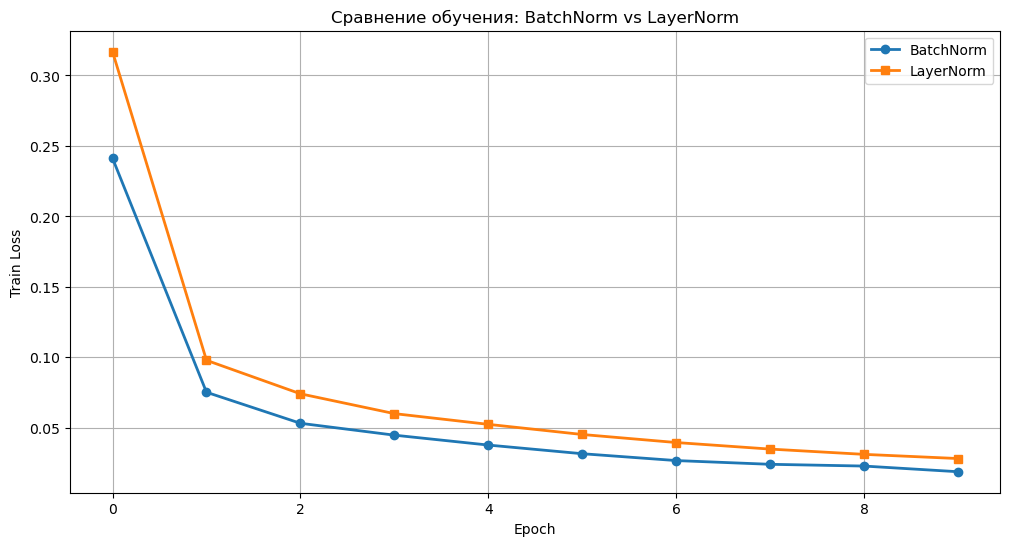

In [62]:
class TestNetworkWithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.flatten = nn.Flatten()
        
        self.final_part = nn.Sequential(
            nn.Linear(196, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

class TestNetworkWithLayerNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.flatten = nn.Flatten()
        
        self.final_part = nn.Sequential(
            nn.Linear(196, 128),
            LayerNormalization(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            LayerNormalization(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

network_batchnorm = TestNetworkWithBatchNorm()
network_layernorm = TestNetworkWithLayerNorm()

optimizer_bn = torch.optim.Adam(network_batchnorm.parameters(), lr=0.001)
optimizer_ln = torch.optim.Adam(network_layernorm.parameters(), lr=0.001)

loss_fn = torch.nn.NLLLoss()

batchnorm_train_losses = []
layernorm_train_losses = []

for epoch in range(10):

    network_batchnorm.train()
    network_layernorm.train()
    
    bn_epoch_train_loss = 0
    ln_epoch_train_loss = 0
    num_batches = 0
    
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):

        optimizer_bn.zero_grad()
        output_bn = network_batchnorm(images_train)
        loss_bn = loss_fn(output_bn, labels_train)
        loss_bn.backward()
        optimizer_bn.step()
        bn_epoch_train_loss += loss_bn.item()
         
        optimizer_ln.zero_grad()
        output_ln = network_layernorm(images_train)
        loss_ln = loss_fn(output_ln, labels_train)
        loss_ln.backward()
        optimizer_ln.step()
        ln_epoch_train_loss += loss_ln.item()
        
        num_batches += 1
    
    avg_bn_loss = bn_epoch_train_loss / num_batches
    avg_ln_loss = ln_epoch_train_loss / num_batches
    
    batchnorm_train_losses.append(avg_bn_loss)
    layernorm_train_losses.append(avg_ln_loss)

    print(f'Epoch {epoch}:')
    print(f'  BatchNorm - Train Loss: {avg_bn_loss:.4f}')
    print(f'  LayerNorm - Train Loss: {avg_ln_loss:.4f}')

plt.figure(figsize=(12, 6))

plt.plot(batchnorm_train_losses, label='BatchNorm', linewidth=2, marker='o')
plt.plot(layernorm_train_losses, label='LayerNorm', linewidth=2, marker='s')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Сравнение обучения: BatchNorm vs LayerNorm')
plt.legend()
plt.grid(True)
plt.show()